# 1. Data Preparation and Feature Extraction

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
import scipy.sparse as sp
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
# Check for NaN values in the training data set

print(train_df.isnull().sum())
print(test_df.isnull().sum())

# From the result we can see that we only have 2 NaN values in the train set, because
# the number is relative small compared to the entire data set,
# we choose to delete them directly.
train_df = train_df.dropna()

user_reputation    0
reply_count        0
thumbs_up          0
thumbs_down        0
best_score         0
text               2
stars              0
dtype: int64
user_reputation    0
reply_count        0
thumbs_up          0
thumbs_down        0
best_score         0
text               0
stars              0
dtype: int64


In [38]:
# Check how many rows are there in the train and test dataset
print(train_df.shape[0])
print(test_df.shape[0])

14543
3637


In [39]:
# Check how many rows are there for 'stars' == 0 in the train dataset
number_of_rows_train = len(train_df[train_df['stars'] == 0])
print(f"Number of rows with stars is 0 in train dataset: {number_of_rows_train}")

# Check how many rows are there for 'stars' == 0 in the test dataset
number_of_rows_test = len(test_df[test_df['stars'] == 0])
print(f"Number of rows with stars is 0 in test dataset: {number_of_rows_test}")

Number of rows with stars is 0 in train dataset: 1356
Number of rows with stars is 0 in test dataset: 340


In [40]:
# We can see from the above results that less than 10% of the data has a star of 0, according to the requirement
# I choose to drop the rows where 'stars' == 0 as a step of my data cleaning
train_df = train_df.drop(train_df[train_df.stars == 0].index)
test_df = test_df.drop(test_df[test_df.stars == 0].index)

<ipython-input-41-2be01bd97ccd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr(method='spearman')  # Use Spearman's rank correlation


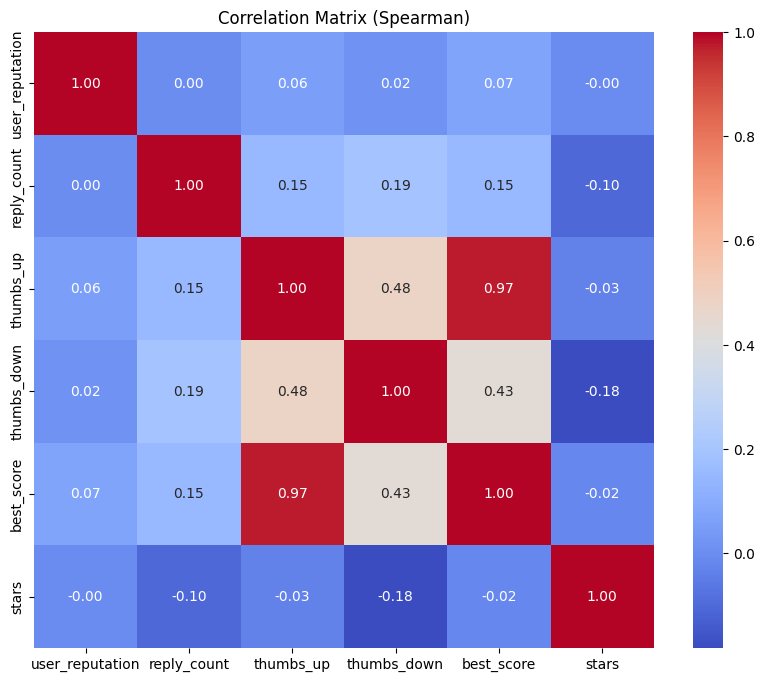

In [41]:
# Use Pearson's correlation to see the relation between each numerical values
corr_matrix = train_df.corr(method='spearman')  # Use Spearman's rank correlation

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (Spearman)')
plt.show()

# From the correlation matrix we can see that there is a relatively high correlation between thumb_up and best_score,
# so I choose to only include best_score for my later analysis

In [42]:
# Define a function to perform okenization of text column

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Contractions dictionary
contractions_dict = {
    "don't": "do not",
    "can't": "cannot",
    "doesn’t": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "wasn't": "was not",
    "won't": "will not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "isn't": "is not",
    "weren't": "were not",
    "aren't": "are not",
    "ain't": "is not"
}

# Compile the contraction dict for faster access
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function to expand contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Updated clean_text function
def clean_text(text):
    # Replace user mentions with a generic token
    text = re.sub(r'@\w+', '@user', text)
    # Convert text to lowercase
    text = text.lower()
    # Expand contractions
    text = expand_contractions(text)
    # Preserve emphasis while removing non-alphanumeric characters, except for apostrophes
    text = re.sub(r'(.)\1+', r'\1\1', text)  # Adjust the repetition as needed
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin words
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Apply the function to the dataset
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# After cleaning, determine the frequency of each word
all_words_train = [word for text in train_df['cleaned_text'] for word in text.split()]
word_freq_train = Counter(all_words_train)

all_words_test = [word for text in test_df['cleaned_text'] for word in text.split()]
word_freq_test = Counter(all_words_test)

# Identify and filter out rare words based on a chosen threshold
threshold = 3
rare_words_train = {word for word, freq in word_freq_train.items() if freq < threshold}
train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in rare_words_train]))

rare_words_test = {word for word, freq in word_freq_test.items() if freq < threshold}
test_df['cleaned_text'] = test_df['cleaned_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in rare_words_test]))



In [43]:
# Initialize CountVectorizer with max_features=800
vectorizer = CountVectorizer(max_features=800)

# Fit the vectorizer on the training data's cleaned_text and transform the training data
X_train = vectorizer.fit_transform(train_df['cleaned_text'])

# Transform the test data using the already fitted vectorizer
X_test = vectorizer.transform(test_df['cleaned_text'])


In [44]:
# Feature extraction: review length
train_df['review_length'] = train_df['cleaned_text'].apply(len)
test_df['review_length'] = test_df['cleaned_text'].apply(len)

In [45]:
# Data preprocessing: Normalization of numerical values for a better comparison
def normalize_feature(dataframe, features):

    for feature in features:
        dataframe[feature] = (dataframe[feature] - dataframe[feature].min()) / (dataframe[feature].max() - dataframe[feature].min())
    return dataframe

# List of feature to normalize
feature_to_normalize = ['best_score', 'review_length', 'thumbs_down', 'user_reputation', 'reply_count', 'thumbs_up']

# Apply the normalization function to DataFrame
train_df = normalize_feature(train_df, feature_to_normalize)
test_df = normalize_feature(test_df, feature_to_normalize)

In [46]:
# Convert 'review_length' to a sparse format for both train and test sets

X_train_selected = sp.csr_matrix(train_df[['review_length','best_score','thumbs_down','user_reputation','reply_count']])
X_test_selected = sp.csr_matrix(test_df[['review_length','best_score','thumbs_down','user_reputation','reply_count']])

# Concatenate text features with 'user_reputation' and 'best_score'
X_train = sp.hstack([X_train, X_train_selected], format='csr')
X_test = sp.hstack([X_test, X_test_selected], format='csr')

In [47]:
# Define the target variable y_train and y_test as the stars each comment has
y_train = train_df['stars']
y_test = test_df['stars']

# 2. Model Selection and Training

## Model selection 1: Decision Trees

In [48]:
# Initialize the classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

print(f"Decision Tree Model Accuracy: {accuracy_dt:.2f}")



Decision Tree Model Accuracy: 0.79


In [49]:
print("Decision Tree Confusion Matrix:\n", conf_matrix_dt)
print("Decision Tree Classification Report:\n", class_report_dt)

Decision Tree Confusion Matrix:
 [[  12    3    2    5   24]
 [   6    4    7    5   22]
 [   7    3   16   16   56]
 [   5    8   15   54  239]
 [  20   11   36  188 2533]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           1       0.24      0.26      0.25        46
           2       0.14      0.09      0.11        44
           3       0.21      0.16      0.18        98
           4       0.20      0.17      0.18       321
           5       0.88      0.91      0.89      2788

    accuracy                           0.79      3297
   macro avg       0.33      0.32      0.32      3297
weighted avg       0.78      0.79      0.78      3297



## Model selection 2: Random Forest

In [50]:

# Initialize RandomForestClassifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100,
                                       random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.85


In [51]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(f"Confusion Matrix:\n{conf_matrix}")

# Detailed classification report
class_report = classification_report(y_test, y_pred_rf)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[[   5    0    1    0   40]
 [   0    1    2    0   41]
 [   0    0    9    1   88]
 [   1    1    3   17  299]
 [   2    0    5    1 2780]]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.11      0.19        46
           2       0.50      0.02      0.04        44
           3       0.45      0.09      0.15        98
           4       0.89      0.05      0.10       321
           5       0.86      1.00      0.92      2788

    accuracy                           0.85      3297
   macro avg       0.67      0.25      0.28      3297
weighted avg       0.84      0.85      0.80      3297



**Here I use random Forest here as my final classifier and my accuracy.csv and pred.csv is based on this random forest model.**



In [ ]:
#Save my prediction into a csv file
pred = pd.Series(y_pred_rf).to_csv('pred.csv', index=False, header=False)

In [52]:
# Export accuracy to csv
accuracy = pd.Series(accuracy).to_csv('accuracy.csv', index=False, header=False)

In [53]:
class_distribution = y_train.value_counts()
print("Class distribution in y_train:")
print(class_distribution)

Class distribution in y_train:
5    11039
4     1334
3      392
1      234
2      188
Name: stars, dtype: int64


In [54]:
# Here I choose to adjust the balance of different class weights because star 5 have an imbalanced high probablity among all results
class_weights = "balanced"

# Initialize RandomForestClassifier with balanced class weights
rf_classifier_balance = RandomForestClassifier(n_estimators=100,
                                       class_weight=class_weights,
                                       random_state=42)

# Train the classifier
rf_classifier_balance.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [55]:
# Predict on the test data
y_pred_rf_w = rf_classifier_balance.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_rf_w)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.85


In [56]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf_w)
print(f"Confusion Matrix:\n{conf_matrix}")

# Detailed classification report
class_report = classification_report(y_test, y_pred_rf_w)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[[   3    0    0    0   43]
 [   0    1    2    0   41]
 [   0    0    6    0   92]
 [   1    1    2   16  301]
 [   1    0    4    6 2777]]
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.07      0.12        46
           2       0.50      0.02      0.04        44
           3       0.43      0.06      0.11        98
           4       0.73      0.05      0.09       321
           5       0.85      1.00      0.92      2788

    accuracy                           0.85      3297
   macro avg       0.62      0.24      0.26      3297
weighted avg       0.82      0.85      0.79      3297



## Model selection 3: Naive Bayes

In [57]:

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)


MultinomialNB()

In [58]:

# Predict the comment scores on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Test Set Accuracy: {test_accuracy:.2f}")


Test Set Accuracy: 0.81


In [59]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:")
print(conf_matrix)


# Generate classification report
class_report = classification_report(y_test, y_pred_nb)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[  11    5    5    4   21]
 [   4    4   12    9   15]
 [  10    4   19   26   39]
 [   5    5   15  107  189]
 [  35   21   23  192 2517]]
Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.24      0.20        46
           2       0.10      0.09      0.10        44
           3       0.26      0.19      0.22        98
           4       0.32      0.33      0.32       321
           5       0.91      0.90      0.90      2788

    accuracy                           0.81      3297
   macro avg       0.35      0.35      0.35      3297
weighted avg       0.81      0.81      0.81      3297



## Questions

### a. How does the performance of your model vary across different classes? Analyze and discuss your observations regarding the precision and recall metrics for each class.

Decision Tree Model
1. **Class 1-4**: These classes have low precision and recall, indicating a significant number of false positives and false negatives. The model struggles to correctly identify these classes, which could be due to a lack of distinguishing features or not enough training data for these classes.
2. **Class 5**: This class has high precision and recall, showing that the model performs well in identifying this class. This could be because the features of this class are well-defined or there is a significant amount of data for this class in the training set.

Random Forest Model
1. **Class 1-4**: Precision and recall are improved in comparison to the Decision Tree model, especially for class 1. However, these classes still show lower performance metrics than class 5, suggesting that while the Random Forest model handles the data's complexity better, there are still challenges.
2. **Class 5**: Consistently high precision and recall indicate that the Random Forest model is very effective in predicting this class, likely due to the ensemble approach that corrects the overfitting of individual decision trees.

Naive Bayes Model
1. **Class 1-4**: These classes show an interesting pattern with precision being relatively higher than recall in some cases (class 4), and vice versa in others (class 1). This suggests that the Naive Bayes model has variable effectiveness, possibly due to the assumption of feature independence, which might not hold true for this data.
2. **Class 5**: The precision and recall are both high, though not as high as in the Random Forest model. This class seems to be the easiest to predict across all models, but Naive Bayes does not perform as well as Random Forest.

Summary and recommendations
1. The high number of support for class 5 suggests a class imbalance, which often leads to models being biased towards the majority class. This could be why class 5 consistently shows better performance across all models.
2. Precision measures the correctness of the predictions made by the model, whereas recall measures the model's ability to find all relevant instances. A trade-off between precision and recall is common; however, in a real-world application, the importance of either metric may vary based on the cost of false positives versus false negatives.
3. In this example, Random Forest classifier shows the highest accuracy, In the future we may also consider ensemble or hybrid models that can leverage the strengths of different algorithms for improved overall performance.

### b. Considering your analysis, how would you recommend using this model in a real- world application? Discuss any limitations or considerations that should be taken into account.



1. Given the evident class imbalance, particularly with the dominance of Class 5, techniques like resampling the dataset, using class weights, or applying anomaly detection methods for minority classes could be beneficial.
2. Here I choosed to Use Random Forest for a balance between interpretability and performance, especially if there's a need for robustness against overfitting would be the best choice for the dataset, although there needs to be a clear understanding of the trade-off between precision and recall. **Here I use random Forest here as my final classifier and my accuracy.csv and pred.csv is based on accuracy from the random forest model.**
3. Depending on the application, we might prefer to maximize one at the expense of the other. For instance, in fraud detection, a high recall might be more desirable to catch as many fraud cases as possible, even if it means dealing with some false positives.
4. Consider the computational resources required for model training and prediction. Here, Random Forest may require more resources due to its ensemble nature, which might be a limitation in resource-constrained environments.


### c. Analyze your data to address the previously identified accuracy issues. Describe your method to address this issue, implement it in code and retrain a classifier, and assess any improvements or ongoing challenges. Your evaluation will be based on your method's appropriateness, not the results.

1. I noticed that the dataset is imbalanced, with the highest proportion occupied by 5-star ratings. So I try to adjust the balance by setting the `class_weights` variable to "balanced". However, there isn't much change in the accuracy, and neither does the precise or recall, we also see a slight decrease in f1 score, this means weight is not a good parameter here for this dataset, and I may choose to use some grid search or emsemble models for future analysis to potentially achieve a higher accuracy.
2. In this case, therefore, I choose to export pred.csv based on my original random forest classifier.

